In [1]:
# %pip uninstall torch torchvision torchaudio transformers mamba-ssm tqdm pandas scikit-learn numpy -y
# %pip cache purge
# %pip install peft torch transformers mamba-ssm tqdm pandas scikit-learn numpy


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

In [3]:
splice_df = pd.read_csv('splice_sites_full_centered_balanced_correct_V3.csv')
splice_df.head()

,id,coord,kind,transcript,strand,chrom,start,end,sequence,win_start,win_end,is_truncated,motif_len,motif
0,NC_050096.1_35318_donor,35318,0,XM_020544715.3,+,NC_050096.1,35319,35320,GGGCCCGGCTGGGCCTCAGCGGGGTCGTCGAGATGGAGATGGGGAG...,35118,35520,False,2,GT
1,NC_050096.1_34607_acceptor,34607,1,XM_020544715.3,+,NC_050096.1,34605,34606,TCCGGTGATTAATTTGTCCTTATACCTTTACAACAAAAATTCACTA...,34404,34806,False,2,TG
2,NC_050096.1_36174_donor,36174,0,XM_020544715.3,+,NC_050096.1,36175,36176,ATAATATGTTCATTATATCACAACACTCTTTTCTTATGGAGTCGTG...,35974,36376,False,2,GT
3,NC_050096.1_36037_acceptor,36037,1,XM_020544715.3,+,NC_050096.1,36035,36036,GCACAAAACTAACTAAAGGAATCATTCTGATAGATAACACTATAAA...,35834,36236,False,2,AG
4,NC_050096.1_36504_donor,36504,0,XM_020544715.3,+,NC_050096.1,36505,36506,TGTCATTTCCTTACCTCATTGAATCATTTCCGATGCTTCTTCTCTG...,36304,36706,False,2,GT


In [4]:
# Split data with stratification
train_df, temp_df = train_test_split(splice_df, test_size=0.3, stratify=splice_df['kind'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['kind'], random_state=42)

## Full Pipeline

In [5]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4


In [6]:
# Cell 1: Imports and Setup
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, AutoConfig
from mamba_ssm import Mamba
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

In [7]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [8]:
# Cell 2: Dataset Class (Modified)
class DNASequenceDataset(Dataset):
    def __init__(self, sequences, labels, max_length=512):
        self.sequences = sequences
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.max_length = max_length
        self.nuc_to_idx = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': 4, 'P': 5}
        
        self.seq_encodings = []
        for seq in sequences:
            encoding = [self.nuc_to_idx.get(nuc, self.nuc_to_idx['N']) for nuc in seq[:max_length]]
            encoding += [self.nuc_to_idx['P']] * (max_length - len(encoding))
            self.seq_encodings.append(torch.tensor(encoding, dtype=torch.long))
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'sequence': self.seq_encodings[idx],
            'label': self.labels[idx]
        }

In [23]:
class MambaSequenceClassifier(nn.Module):
    def __init__(self, d_model=128, d_state=16, d_conv=4, expand=2, num_mamba_layers=4, n_classes=3, max_length=512):
        super().__init__()
        self.nuc_embedding = nn.Embedding(6, d_model)  # ACGTNP to d_model
        self.pos_embedding = nn.Embedding(max_length, d_model)  # Learnable positional embeddings

        nn.init.xavier_uniform_(self.nuc_embedding.weight)
        nn.init.xavier_uniform_(self.pos_embedding.weight)
        
        self.mamba = nn.Sequential(*[
            nn.Sequential(
                nn.LayerNorm(d_model),
                Mamba(
                    d_model=d_model,
                    d_state=d_state,
                    d_conv=d_conv,
                    expand=expand,
                    use_fast_path=True
                ),
                nn.Dropout(0.1)
            ) for _ in range(num_mamba_layers)
        ])

        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(0.1),
            nn.Linear(d_model, n_classes)
        )
        
        self.attention_pool = nn.Sequential(
            nn.Linear(d_model, 1),
            nn.Softmax(dim=1)
        )
            
    def forward(self, sequence, labels=None):
        pos_ids = torch.arange(sequence.size(1), device=sequence.device).unsqueeze(0).expand(sequence.size(0), -1)
        x = self.nuc_embedding(sequence) + self.pos_embedding(pos_ids)  # Add position to nucleotide embeddings
        x = self.mamba(x)
        weights = self.attention_pool(x)  # [B, T, 1]
        x = (x * weights).sum(dim=1)
        logits = self.classifier(x)
        
        if labels is not None:
            loss = nn.CrossEntropyLoss(label_smoothing=0.1)(logits, labels)
            return loss, logits
        return None, logits


In [24]:
# Cell 4: Model Initialization (Modified)
def prepare_model_and_data(train_df, test_df, sample_size=5000, max_length=512):
    train_sample = train_df.groupby('kind', group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), sample_size // 3))
    ).reset_index(drop=True)

    test_sample = test_df.groupby('kind', group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), sample_size // 15))
    ).reset_index(drop=True)
    
    train_dataset = DNASequenceDataset(
        sequences=train_sample['sequence'].tolist(),
        labels=train_sample['kind'].tolist(),
        max_length=max_length
    )
    
    test_dataset = DNASequenceDataset(
        sequences=test_sample['sequence'].tolist(),
        labels=test_sample['kind'].tolist(),
        max_length=max_length
    )
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=32)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MambaSequenceClassifier(
        d_model=128,
        d_state=16,
        d_conv=4,
        expand=1,
        num_mamba_layers=4,
        n_classes=3
    ).to(device)
    
    return model, train_dataloader, test_dataloader, device


In [25]:
# Cell 5: Training Function (Modified)
def train_model(model, train_dataloader, val_dataloader, device, 
                num_epochs=10, patience=3, learning_rate=1e-4):
    
    # Initialize optimizer and tracking variables
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    # Initialize tracking lists
    history = {
        'epoch': [], 'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [], 'learning_rate': []
    }
    
    for epoch in range(num_epochs):

        # Training phase
        model.train()
        total_train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            sequence = batch['sequence'].to(device)
            labels = batch['label'].to(device)  # Changed from 'labels' to 'label'
            
            optimizer.zero_grad()
            loss, logits = model(sequence, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            total_train_loss += loss.item()
            
            # Calculate accuracy
            predictions = torch.argmax(logits, dim=1)
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)
        
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_accuracy = train_correct / train_total
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in val_dataloader:
                sequence = batch['sequence'].to(device)
                labels = batch['label'].to(device)  # Changed from 'labels' to 'label'
                
                loss, logits = model(sequence, labels)
                total_val_loss += loss.item()
                
                # Calculate accuracy
                predictions = torch.argmax(logits, dim=1)
                val_correct += (predictions == labels).sum().item()
                val_total += labels.size(0)
        
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = val_correct / val_total
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Save history
        history['epoch'].append(epoch + 1)
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_accuracy)
        history['val_acc'].append(val_accuracy)
        history['learning_rate'].append(current_lr)
        
        # Print metrics
        print(f'Epoch {epoch + 1}/{num_epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
        print(f'Learning Rate: {current_lr}')
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping triggered after epoch {epoch + 1}')
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Convert history to DataFrame
    history_df = pd.DataFrame(history)
    return history_df

In [ ]:
# Cell 6: Run the Pipeline
# Initialize model and data
model, train_dataloader, test_dataloader, device = prepare_model_and_data(
    train_df=train_df,
    test_df=test_df,
    sample_size=50000
)

# Train the model
history_df = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=test_dataloader,
    device=device,
    num_epochs=20,
    patience=10,
    learning_rate=1e-4
)

Epoch 1/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1/20:
Train Loss: 0.7048, Train Acc: 0.7489
Val Loss: 0.5320, Val Acc: 0.8714
Learning Rate: 0.0001


Epoch 2/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2/20:
Train Loss: 0.5126, Train Acc: 0.8840
Val Loss: 0.4895, Val Acc: 0.8929
Learning Rate: 0.0001


Epoch 3/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3/20:
Train Loss: 0.4784, Train Acc: 0.9027
Val Loss: 0.4704, Val Acc: 0.9039
Learning Rate: 0.0001


Epoch 4/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4/20:
Train Loss: 0.4574, Train Acc: 0.9137
Val Loss: 0.4687, Val Acc: 0.9068
Learning Rate: 0.0001


Epoch 5/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5/20:
Train Loss: 0.4402, Train Acc: 0.9238
Val Loss: 0.4470, Val Acc: 0.9216
Learning Rate: 0.0001


Epoch 6/20:   0%|          | 0/1563 [00:00<?, ?it/s]

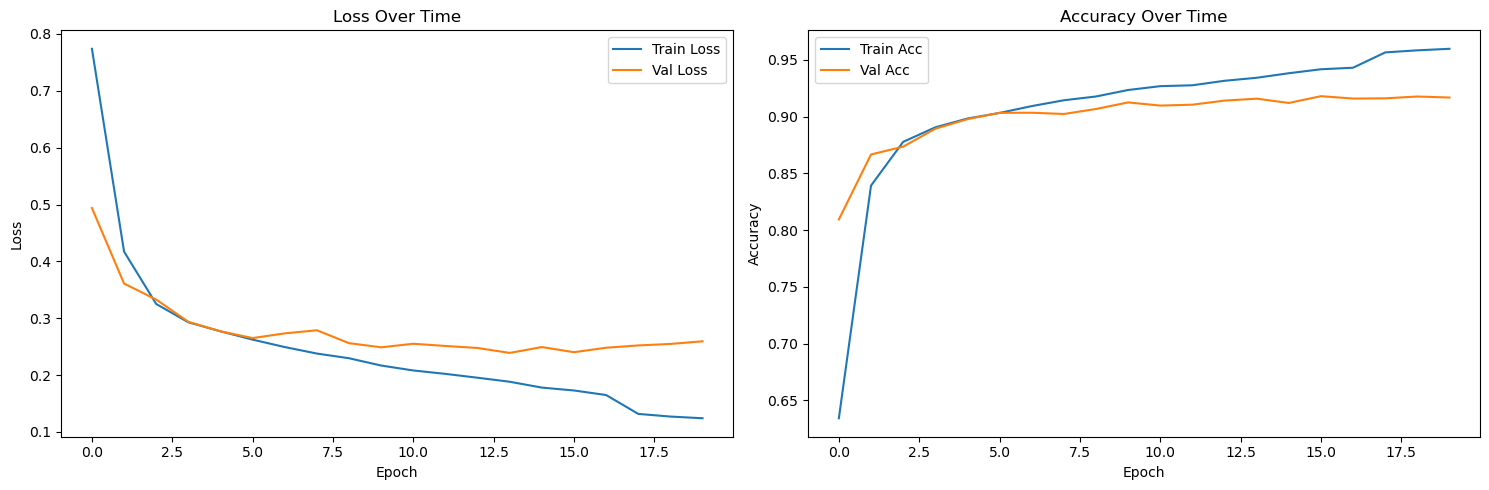

In [13]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_df['train_loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Val Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['train_acc'], label='Train Acc')
plt.plot(history_df['val_acc'], label='Val Acc')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Cell 7: Compute Test Accuracy
def compute_test_accuracy(model, test_dataloader, device):
    model.eval()
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for batch in test_dataloader:
            sequence = batch['sequence'].to(device)
            labels = batch['label'].to(device)
            
            _, logits = model(sequence)
            predictions = torch.argmax(logits, dim=1)
            test_correct += (predictions == labels).sum().item()
            test_total += labels.size(0)
    
    test_accuracy = test_correct / test_total
    print(f"Test Accuracy: {test_accuracy:.4f}")

# Compute test accuracy
compute_test_accuracy(model, test_dataloader, device)

Test Accuracy: 0.9169
